# Part 1:  Preprocessing and EDA

- The data comes from a global e-retailer company, including orders from 2012 to 2015. Import the **Orders** dataset and do some basic EDA. 
- For problem 1 to 3, we mainly focus on data cleaning and data visualizations. You can use all the packages that you are familiar with to conduct some plots and also provide **brief interpretations** about your findings.

## Problem 1: Dataset Import and Cleaning

Check **"Profit"** and **"Sales"** in the dataset, convert these two columns to numeric type. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline
plt.style.use('ggplot')

In [2]:
#Read data and assign to variable names
returns = pd.read_csv('./data/Returns.csv')
orders = pd.read_csv('./data/Orders.csv')

In [3]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)

In [4]:
#Look at column names
orders.columns

Index(['Row.ID', 'Order.ID', 'Order.Date', 'Ship.Date', 'Ship.Mode',
       'Customer.ID', 'Customer.Name', 'Segment', 'Postal.Code', 'City',
       'State', 'Country', 'Region', 'Market', 'Product.ID', 'Category',
       'Sub.Category', 'Product.Name', 'Sales', 'Quantity', 'Discount',
       'Profit', 'Shipping.Cost', 'Order.Priority'],
      dtype='object')

In [5]:
returns.columns

Index(['Returned', 'Order ID', 'Region'], dtype='object')

In [6]:
#Looks for missing data per column. 
orders.isnull().sum()

Row.ID                0
Order.ID              0
Order.Date            0
Ship.Date             0
Ship.Mode             0
Customer.ID           0
Customer.Name         0
Segment               0
Postal.Code       41296
City                  0
State                 0
Country               0
Region                0
Market                0
Product.ID            0
Category              0
Sub.Category          0
Product.Name          0
Sales                 0
Quantity              0
Discount              0
Profit                0
Shipping.Cost         0
Order.Priority        0
dtype: int64

In [7]:
returns.isnull().sum()

Returned    0
Order ID    0
Region      0
dtype: int64

In [8]:
#Look at dimentions of the data sets.
orders.shape

(51290, 24)

In [9]:
returns.shape

(1079, 3)

In [10]:
#Looks like we need to get rid of $ and commas
orders['Profit'].head()

0      $62.15
1    -$288.77
2     $919.97
3     -$96.54
4     $311.52
Name: Profit, dtype: object

In [11]:
#Remove the $ and commas in the Profit and Sales columns. 
for category in ['Profit', 'Sales']:
    orders[category] = pd.to_numeric(orders[category].str.replace('$', '').str.replace(',', ''))


## Problem 2: Inventory Management
- Retailers that depend on seasonal shoppers have a particularly challenging job when it comes to inventory management. Your manager is making plans for next year's inventory.
- He wants you to answer the following questions:
    1. Is there any seasonal trend of inventory in the company?
    2. Is the seasonal trend the same for different categories?

- ***Hint:*** For each order, it has an attribute called `Quantity` that indicates the number of product in the order. If an order contains more than one product, there will be multiple observations of the same order.

In [12]:
#check the type for Order Date... String
type(orders['Order.Date'][1])

str

In [13]:
#Take the Month by doing a string split.
orders['Month'] = pd.to_numeric(orders['Order.Date'].str.split('/').map(lambda x: x[0]))

#pd.DatetimeIndex(orders['Order.Date']).month


<Figure size 864x432 with 0 Axes>

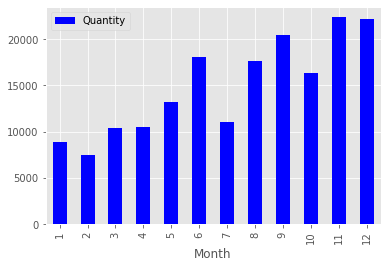

In [14]:
# Plot inventory (sum of quantity) by grouped by month.
plt.figure(figsize=(12,6))
orders.groupby('Month').agg({'Quantity':'sum'}).plot.bar(color='b')

In [15]:
#Also group by Category
agg_orders = orders.groupby(['Month', 'Category']).agg({'Quantity':'sum'}).reset_index()

In [16]:
#Create a filtered data frame for each category to plot later.
f = agg_orders.loc[agg_orders.Category=="Furniture"]
t = agg_orders.loc[agg_orders.Category=="Technology"]
o = agg_orders.loc[agg_orders.Category=="Office Supplies"]

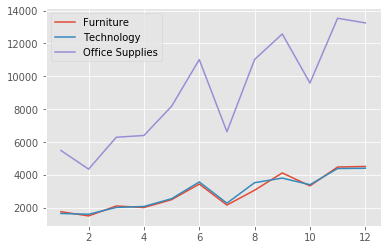

In [17]:
#Create a line plot with lines representing each category.
plt.plot('Month', "Quantity", data=f, marker='', markerfacecolor='blue', label = "Furniture")
plt.plot('Month', "Quantity", data=t, marker='', markerfacecolor='blue', label = "Technology")
plt.plot('Month', "Quantity", data=o, marker='', markerfacecolor='blue', label = "Office Supplies")
plt.legend()


## Problem 3: Why did customers make returns?
- Your manager required you to give a brief report (**Plots + Interpretations**) on returned orders.

### 3.1 How much profit did we lose due to returns each year?

In [18]:
returns.head()

,Returned,Order ID,Region
0,Yes,CA-2012-SA20830140-41210,Central US
1,Yes,IN-2012-PB19210127-41259,Eastern Asia
2,Yes,CA-2012-SC20095140-41174,Central US
3,Yes,IN-2015-JH158207-42140,Oceania
4,Yes,IN-2014-LC168857-41747,Oceania


In [19]:
returns.Returned.value_counts() #all Yes, no No's

Yes    1079
Name: Returned, dtype: int64

In [20]:
#Merge with Sales and sum the profits from only those returned. 
merged = returns.merge(orders, how='left', left_on='Order ID', right_on='Order.ID')
merged['Profit'].sum() #$61,370 total

61370.75

In [21]:
#Finding the Lost Profit grouped by Year
merged['Year'] = pd.DatetimeIndex(merged['Order.Date']).year
profit_loss_by_year = merged.groupby('Year')['Profit'].sum()
profit_loss_by_year

Year
2012    17477.26
2013     9269.89
2014    17510.63
2015    17112.97
Name: Profit, dtype: float64

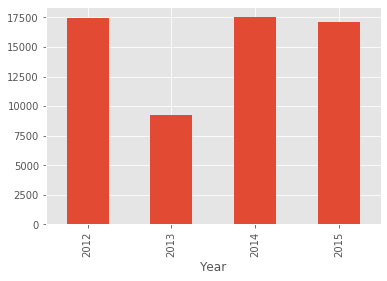

In [22]:
#Barplot of Loss of Profit from Returns by Year
plt.figure()
profit_loss_by_year.plot.bar()

### 3.2 How many customers returned more than once? more than 5 times?


In [23]:
#Count the number of returns by Customer.ID
counts_by_custID = merged.groupby('Customer.ID').count()
#Filter the dataframe for counts greater than 1
counts_by_custID.loc[counts_by_custID.Returned>1]['Returned'].count() #547

547

In [24]:
#Filter the dataframe for counts greater than 5
counts_by_custID.loc[counts_by_custID.Returned>5]['Returned'].count() #46

46

### 3.3 Which regions are more likely to return orders?


In [25]:
#Group by Region and sort the counts of returns.
returned_by_region = merged.groupby('Region_x').count().Returned.sort_values(ascending=False)
returned_by_region  #Central America, Western Europe, and Western US are the top 3


Region_x
Central America      248
Western Europe       233
Western US           180
Oceania              154
Southeastern Asia    140
Eastern US           134
South America        133
Eastern Asia         131
Southern Europe      112
Southern Asia        111
Western Asia         108
Southern US           83
Northern Europe       76
Central US            71
Caribbean             69
Western Africa        60
North Africa          51
Eastern Europe        42
Southern Africa       25
Eastern Africa        18
Central Africa        17
Eastern Canada        10
Central Asia           9
Western Canada         5
Name: Returned, dtype: int64

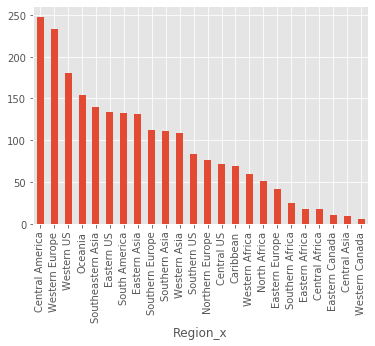

In [26]:
#Barplot of Regions with the Most Returns
plt.figure()
returned_by_region.plot.bar()

### 3.4 Which categories (sub-categories) of products are more likely to be returned?

In [27]:
#Sort the number of returns grouped by Category.
returned_by_cat = merged.groupby('Category').count().Returned.sort_values(ascending=False)
returned_by_cat

Category
Office Supplies    1348
Technology          445
Furniture           427
Name: Returned, dtype: int64

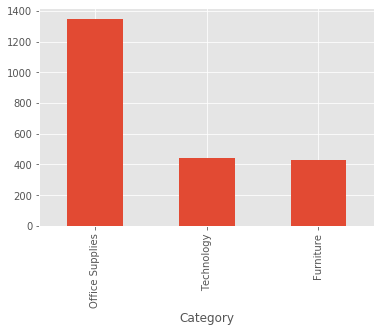

In [28]:
#Barplot of Category with the Most Returns
plt.figure()
returned_by_cat.plot.bar()

In [29]:
#Subcategories sorted by number of returns
returned_by_subcat = merged.groupby('Sub.Category').count().Returned.sort_values(ascending=False)
returned_by_subcat

Sub.Category
Binders        269
Art            217
Storage        212
Paper          150
Chairs         147
Phones         145
Accessories    138
Labels         137
Furnishings    135
Bookcases      104
Supplies       103
Fasteners      102
Copiers         99
Envelopes       99
Machines        63
Appliances      59
Tables          41
Name: Returned, dtype: int64

In [30]:
#Group the returns by Category and Subcategory
returned_grouped_cats = merged.groupby(["Category", 'Sub.Category']).count().reset_index()

In [31]:
#Filter the returns by Category to plot later.
furniture_return_cnt = returned_grouped_cats.loc[returned_grouped_cats.Category == "Furniture"]
technology_return_cnt = returned_grouped_cats.loc[returned_grouped_cats.Category == "Technology"]
officesupplies_return_cnt = returned_grouped_cats.loc[returned_grouped_cats.Category == "Office Supplies"]

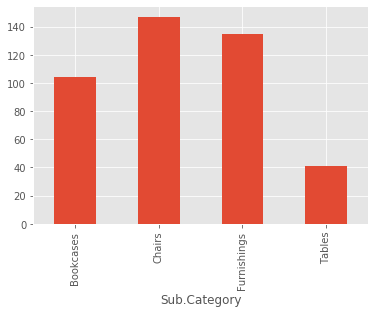

In [32]:
#Furniture Return Counts
plt.figure()
furniture_return_cnt.set_index('Sub.Category')["Returned"].plot.bar()

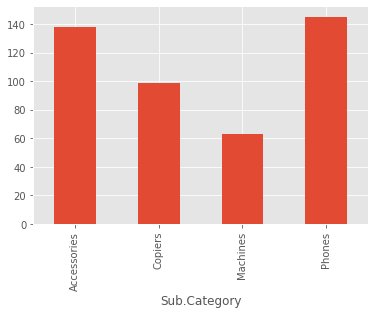

In [33]:
#Technology Return Counts
plt.figure()
technology_return_cnt.set_index('Sub.Category')["Returned"].plot.bar()

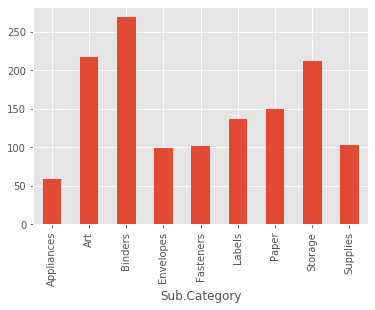

In [34]:
#Office Supply Return Counts
plt.figure()
officesupplies_return_cnt.set_index('Sub.Category')["Returned"].plot.bar()

# Part 2 Machine Learning and Business Use Case

Now your manager has a basic understanding of why customers returned orders. Next, he wants you to use machine learning to predict which orders are most likely to be returned. In this part, you will generate several features based on our previous findings and your manager's requirements.


AUC and ROC as showing how good it is.
Also do the classification report, which has F-test, precision, accuracy, etc.

### Problem 4: Feature Engineering
#### Step 1: Create the dependent variable
- First of all, we need to generate a categorical variable which indicates whether an order has been returned or not.
- ***Hint:*** the returned orders’ IDs are contained in the dataset “returns”

In [35]:
returns.sample(5)

,Returned,Order ID,Region
8,Yes,ES-2014-JF15295120-41924,Southern Europe
370,Yes,ES-2012-CD1198048-41151,Western Europe
443,Yes,IR-2014-MM805560-41990,Southern Asia
304,Yes,CA-2012-RD19585140-41000,Southern US
910,Yes,IN-2014-AC1061558-41808,Southern Asia


In [36]:
orders.sample(5)

,Row.ID,Order.ID,Order.Date,Ship.Date,Ship.Mode,Customer.ID,Customer.Name,Segment,Postal.Code,City,State,Country,Region,Market,Product.ID,Category,Sub.Category,Product.Name,Sales,Quantity,Discount,Profit,Shipping.Cost,Order.Priority,Month
16776,13437,IT-2013-LS1723091-41390,4/26/13,5/1/13,Second Class,LS-1723091,Lycoris Saunders,Consumer,NaN,Leeuwarden,Friesland,Netherlands,Western Europe,Europe,TEC-MA-5542,Technology,Machines,"Panasonic Card Printer, Durable",173.94,2,0.5,-104.40,16.660,Medium,4
17985,6764,MX-2015-OT1873082-42105,4/11/15,4/14/15,First Class,OT-1873082,Olvera Toch,Consumer,NaN,Tlalnepantla,México,Mexico,Central America,LATAM,OFF-BI-2902,Office Supplies,Binders,"Acco Binding Machine, Recycled",68.60,2,0.0,26.72,14.961,High,4
48035,41671,TU-2014-AR540134-41807,6/17/14,6/21/14,Second Class,AR-540134,Andy Reiter,Consumer,NaN,Van,Van,Turkey,Western Asia,Asia Pacific,OFF-AR-3464,Office Supplies,Art,"BIC Pens, Blue",5.71,1,0.6,-7.01,1.380,Medium,6
36185,8339,MX-2015-CB1241598-42299,10/22/15,10/27/15,Standard Class,CB-1241598,Christy Brittain,Consumer,NaN,Arraiján,Panama,Panama,Central America,LATAM,FUR-BO-5745,Furniture,Bookcases,"Safco 3-Shelf Cabinet, Metal",67.32,1,0.4,-35.92,3.234,Medium,10
37844,45258,JO-2013-RH951067-41302,1/28/13,2/1/13,Standard Class,RH-951067,Rick Huthwaite,Home Office,NaN,Amman,'Amman,Jordan,Western Asia,Asia Pacific,OFF-SU-6160,Office Supplies,Supplies,"Stiletto Box Cutter, Easy Grip",75.18,2,0.0,4.50,2.780,Medium,1


In [37]:
merged_outer = returns.merge(orders, how='outer', left_on='Order ID', right_on='Order.ID')

In [38]:
merged_outer['Returned'] = merged_outer['Returned'].fillna(0).replace('Yes', 1)

#### Step 2:
- Your manager believes that **how long it took the order to ship** would affect whether the customer would return it or not. 
- He wants you to generate a feature which can measure how long it takes the company to process each order.
- ***Hint:*** Process.Time = Ship.Date - Order.Date

In [39]:
type(merged_outer['Ship.Date'][0])

str

In [40]:
merged_outer['Order.Date'] = pd.DatetimeIndex(merged_outer['Order.Date'])
merged_outer['Ship.Date'] = pd.DatetimeIndex(merged_outer['Ship.Date'])

In [41]:
merged_outer['Process.Time'] = merged_outer['Ship.Date'] - merged_outer['Order.Date']
merged_outer['Process.Time'] = merged_outer['Process.Time'].map(lambda x: x.days)

#### Step 3:

- If a product has been returned before, it may be returned again. 
- Let us generate a feature indictes how many times the product has been returned before.
- If it never got returned, we just impute using 0.
- ***Hint:*** Group by different Product.ID

In [42]:
returned_cnt_pID = merged_outer.groupby('Product.ID').agg('Returned').sum().reset_index()
returned_cnt_pID.columns = ['Product.ID', 'CountReturned']
merged_outer = merged_outer.merge(returned_cnt_pID, how='left', left_on='Product.ID', right_on='Product.ID')

In [43]:
merged_outer.sample(20)

,Returned,Order ID,Region_x,Row.ID,Order.ID,Order.Date,Ship.Date,Ship.Mode,Customer.ID,Customer.Name,Segment,Postal.Code,City,State,Country,Region_y,Market,Product.ID,Category,Sub.Category,Product.Name,Sales,Quantity,Discount,Profit,Shipping.Cost,Order.Priority,Month,Process.Time,CountReturned
49178,0,NaN,NaN,43542,TU-2015-MZ7335134-42119,2015-04-25,2015-04-30,Standard Class,MZ-7335134,Maria Zettner,Home Office,NaN,Ordu,Ordu,Turkey,Western Asia,Asia Pacific,OFF-FA-5463,Office Supplies,Fasteners,"OIC Clamps, Assorted Sizes",6.89,1,0.600,-4.15,1.480,Medium,4,5,0
23689,0,NaN,NaN,8594,US-2015-TB2140055-42160,2015-06-05,2015-06-10,Second Class,TB-2140055,Tom Boeckenhauer,Consumer,NaN,Tegucigalpa,Francisco Morazán,Honduras,Central America,LATAM,OFF-ST-6261,Office Supplies,Storage,"Tenex Lockers, Blue",244.98,3,0.400,-118.44,17.511,Medium,6,5,0
48211,0,NaN,NaN,9727,MX-2014-SC2030582-41872,2014-08-21,2014-08-26,Standard Class,SC-2030582,Sean Christensen,Consumer,NaN,Cuernavaca,Morelos,Mexico,Central America,LATAM,OFF-LA-4685,Office Supplies,Labels,"Hon Round Labels, 5000 Label Set",14.10,3,0.000,2.82,1.653,Medium,8,5,0
6098,0,NaN,NaN,31165,IN-2015-RS1976592-42202,2015-07-17,2015-07-19,First Class,RS-1976592,Roland Schwarz,Corporate,NaN,Timaru,Canterbury,New Zealand,Oceania,Asia Pacific,TEC-CO-3687,Technology,Copiers,"Canon Fax Machine, Digital",636.06,2,0.000,12.72,146.260,High,7,2,2
3034,0,NaN,NaN,29552,IN-2015-SV2078559-42110,2015-04-16,2015-04-18,Second Class,SV-2078559,Stewart Visinsky,Consumer,NaN,Medan,Sumatera Utara,Indonesia,Southeastern Asia,Asia Pacific,OFF-ST-6049,Office Supplies,Storage,"Smead Lockers, Wire Frame",1803.08,11,0.170,-130.39,332.130,High,4,2,1
32789,0,NaN,NaN,10513,ES-2015-LC1696064-42058,2015-02-23,2015-02-27,Standard Class,LC-1696064,Lindsay Castell,Home Office,NaN,Rome,Lazio,Italy,Southern Europe,Europe,OFF-ST-4253,Office Supplies,Storage,"Fellowes Box, Wire Frame",112.50,10,0.400,11.10,11.460,Medium,2,4,2
26478,0,NaN,NaN,24723,IN-2013-CS1240027-41294,2013-01-20,2013-01-22,Second Class,CS-1240027,Christopher Schild,Home Office,NaN,Taiyuan,Shanxi,China,Eastern Asia,Asia Pacific,OFF-BI-2893,Office Supplies,Binders,"Acco Binder Covers, Economy",39.96,3,0.000,5.94,4.340,Medium,1,2,2
4412,0,NaN,NaN,33952,CA-2015-AS10225140-42265,2015-09-18,2015-09-22,Second Class,AS-102251404,Alan Schoenberger,Corporate,84604.0,Provo,Utah,United States,Western US,USCA,OFF-BI-4356,Office Supplies,Binders,"GBC Pre-Punched Binding Paper, Plastic, White,...",25.58,2,0.200,8.95,4.150,Medium,9,4,0
50742,0,NaN,NaN,43791,TU-2013-DJ3630134-41335,2013-03-02,2013-03-06,Standard Class,DJ-3630134,Doug Jacobs,Consumer,NaN,Eskisehir,Eskisehir,Turkey,Western Asia,Asia Pacific,OFF-BI-3292,Office Supplies,Binders,"Avery Hole Reinforcements, Recycled",1.91,1,0.600,-0.82,1.180,Medium,3,4,3
21658,0,NaN,NaN,5103,MX-2015-JB1604593-42320,2015-11-12,2015-11-18,Standard Class,JB-1604593,Julia Barnett,Home Office,NaN,Managua,Managua,Nicaragua,Central America,LATAM,TEC-CO-6009,Technology,Copiers,"Sharp Wireless Fax, Color",475.53,2,0.002,218.21,29.765,Medium,11,6,0


In [44]:
merged_outer.CountReturned.value_counts()

0     21535
1     16007
2      8351
3      3715
4       869
5       379
12      227
6       130
9        77
Name: CountReturned, dtype: int64

### Problem 5: Fitting Models

- You can use any binary classification method you have learned so far.
- Use 80/20 training and test splits to build your model. 
- Double check the column types before you fit the model.
- Only include useful features. i.e all the `ID`s should be excluded from your training set.
- Note that there are only less than 5% of the orders have been returned, so you should consider using the [createDataPartition](https://www.rdocumentation.org/packages/caret/versions/6.0-80/topics/createDataPartition) function from `caret` package and [StratifiedKfold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn-model-selection-stratifiedkfold) from sklearn when running cross-validation.
- Do forget to `set.seed()` before the spilt to make your result reproducible.
- **Note:** We are not looking for the best tuned model in the lab so don't spend too much time on grid search. Focus on model evaluation and the business use case of each model.


In [45]:
#Drop Ship.Date because it's related to Order.Date and Process.Time
#Dropped ID features.
useful_features = ['Returned', 'Ship.Mode', 'Market', 'Category',
                   'Sales', 'Quantity', 'Profit', 'Shipping.Cost', 'Order.Priority',
                  'Month', 'Process.Time', 'CountReturned']
np.random.seed(1)


In [46]:
reduced_df = merged_outer[useful_features]

In [47]:
nom_features = ['Ship.Mode', 'Market', 'Category', 'Order.Priority']

#Dummify the Categorical Variables.
for variable in nom_features:
    dummy = pd.get_dummies(reduced_df[variable], prefix=variable, prefix_sep='_')
    dummy.drop(list(dummy.columns)[0], axis=1, inplace=True) #Drop 1st dummy is the dominant category
    reduced_df.drop(variable, axis=1, inplace=True) #Drop original categorical column
    reduced_df = pd.concat([reduced_df, dummy], axis=1) #concat train with dummy dataframes


/Users/jonpresley/anaconda3/envs/motionflow/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [48]:
from sklearn.model_selection import train_test_split
X = reduced_df.loc[:, reduced_df.columns != 'Returned']
y = reduced_df['Returned']

In [49]:
y.value_counts()

0    49070
1     2220
Name: Returned, dtype: int64

In [50]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, stratify = y)

## Up-Sampling the Minority Class --- SKIP

In [51]:
merged_outer[merged_outer['Returned']==1]['Order ID'].values

array(['CA-2012-SA20830140-41210', 'IN-2012-PB19210127-41259',
       'IN-2012-PB19210127-41259', ..., 'US-2013-SJ2021582-41543',
       'CA-2015-EB13870140-42269', 'EG-2014-PM894038-41846'], dtype=object)

In [52]:
from sklearn.utils import resample
minorIndex = merged_outer[merged_outer['Returned']==1]['Order ID'].values


In [53]:
resampled = resample(minorIndex, n_samples = 49070-2220)
LEFT = pd.DataFrame(list(merged_outer['Order ID']) + list(resampled), columns=['INDEX'])



In [ ]:
merged_outer2 = pd.merge(LEFT, merged_outer, how='left', left_on ='INDEX', right_on='Order ID')

In [ ]:
X = merged_outer2[useful_features]
y = merged_outer2['Returned']

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)

# Logistic Regression

In [51]:
# Fit the logistic Regression model
from sklearn.linear_model import LogisticRegression
# Since this is an imbalanced dataset, setting class_weight='balanced' will give us a better result
# http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
LR = LogisticRegression(class_weight='balanced')
LR.fit(X_train, Y_train)
y_predict = LR.predict(X_test)

/Users/jonpresley/anaconda3/envs/motionflow/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [53]:
# Evaluate the logistic regression model
from sklearn.metrics import confusion_matrix, roc_auc_score
confusion_matrix(Y_test, y_predict)

array([[6974, 2840],
       [ 137,  307]])

In [54]:
# This is an imbalanced dataset so I would achieve more than 95% accuracy rate even if I always predict 'No'. 
# In this case, accuracy is not a good metric. ROC curve or F1 score works better for this task.
roc_auc_score(Y_test, y_predict)

0.701029463333315

# Random Forest

In [55]:
from sklearn import ensemble
randomForest = ensemble.RandomForestClassifier()


In [56]:
randomForest.set_params(random_state=42, n_estimators=1000, class_weight="balanced", max_depth=9, n_jobs=-1)
randomForest.fit(X_train, Y_train) # fit 
y_predict = randomForest.predict(X_test)


In [57]:
# Evaluate the random forest model
confusion_matrix(Y_test, y_predict)

array([[5776, 4038],
       [  88,  356]])

In [59]:
# AUC score
roc_auc_score(Y_test, y_predict)

0.6951743877564134

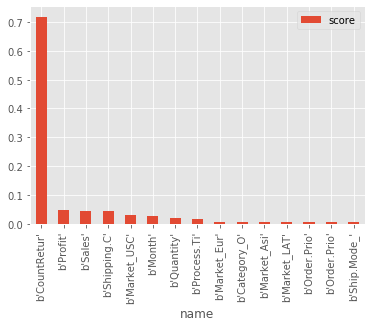

In [60]:
feature_importance = list(zip(X_train.columns, randomForest.feature_importances_))
dtype = [('feature', 'S10'), ('importance', 'float')]
feature_importance = np.array(feature_importance, dtype=dtype)
feature_sort = np.sort(feature_importance, order='importance')[::-1]
name, score = zip(*list(feature_sort))
pd.DataFrame({'name':name,'score':score})[:15].plot.bar(x='name', y='score')

In [61]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, y_predict))

              precision    recall  f1-score   support

           0       0.98      0.59      0.74      9814
           1       0.08      0.80      0.15       444

    accuracy                           0.60     10258
   macro avg       0.53      0.70      0.44     10258
weighted avg       0.95      0.60      0.71     10258



- Now you have multiple models, which one would you pick? 
- Can you get any clue from the confusion matrix? What is the meaning of precision and recall in this case?
- How will your model help the manager make decisions? 
- It really depends your understanding of the business model. For example, if I find a product that has a high probability that will get returned, I would recommend my manager to put it on final sale so the customer get it for a lower price but they are not allowed to return the product. However, if the product turned out to be just fine and we are losing profit because we give it a discount. In that case, I would prefer a model that has a relatively good accuracy with better precision (lower Type I error). 

### Problem 6:
Is there anything wrong with the feature engineering process? How should we fix it?

- The `Return.Times` feature was wrong. If we want to use training data set to fit a model and test dataset to test a model, we assume test dataset is new data we get after fitting the model. But using the whole dataset to count the times will actually indicate these items will be returned in the test dataset. That's why the process is invalid.

- The easiest way to fix the problem is to split the train and test set by different timespan. You can use 2012-2014 data for training and 2015 data as testing. It will mimic the same scenario in real life: **you don't know what's going to happen in the future :)**

- A great [blog post](http://www.fast.ai/2017/11/13/validation-sets/) from fast.ai discussing this problem.